In [1]:
from pathlib import Path
from python.optimization import TopOpt
from python.postprocessor import Post2D, Post3D

ANSYS_path = Path("C:/Program Files/ANSYS Inc/v202/ansys/bin/winx64/MAPDL.exe")
script_dir = Path("python/")
res_dir    = Path("results/")
mod_dir    = Path("models/")
TopOpt.set_paths(ANSYS_path, script_dir, res_dir, mod_dir)

# Test case
- Half MBB 168 mm x 80 mm x 8 mm
- Mesh:
    - **2D**: 42 x 20 elements (4 mm element)
    - **3D**: 42 x 20 x 2 elements (4 mm element)
- 1 kN downward force


- Cellulose and 0.5 bamboo
- volfrac = 0.3
- r_rho = 8
- r_theta = 20
- theta0 = 50°
- 100 iterations

In [2]:
# fiber: bamboo
rhofiber  = 700e-12 # t/mm^3
Efiber    = 17.5e3 # MPa
vfiber    = 0.04
CO2fiber  = 1.0565 # kgCO2/kg

# matrix: cellulose
rhomatrix = 990e-12 # t/mm^3
Ematrix   = 3.25e3
vmatrix   = 0.355 # MPa
CO2matrix = 3.8 # kgCO2/kg

Vfiber  = 0.5
Vmatrix = 1-Vfiber

Gfiber  = Efiber/(2*(1+vfiber))
Gmatrix = Ematrix/(2*(1+vmatrix))

Ex   = Efiber*Vfiber + Ematrix*Vmatrix
Ey   = Efiber*Ematrix / (Efiber*Vmatrix + Ematrix*Vfiber)
Gxy  = Gfiber*Gmatrix / (Gfiber*Vmatrix + Gmatrix*Vfiber)
nuxy = vfiber*Vfiber + vmatrix*Vmatrix
rho  = rhofiber*Vfiber + rhomatrix*Vmatrix

CO2mat = (rhofiber*Vfiber*CO2fiber + rhomatrix*Vmatrix*CO2matrix)/rho # kgCO2/kg
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

In [3]:
solver1 = TopOpt(inputfile='mbb2d', dim='2D', jobname='2d',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.3, r_rho=8, r_theta=20, theta0=50, max_iter=100)
solver1.optim()

print()
print('Total elapsed time     {:7.2f}s'.format(solver1.time))
print('FEA time               {:7.2f}s'.format(solver1.fea_time))
print('Derivation time        {:7.2f}s'.format(solver1.deriv_time))
print('Variable updating time {:7.2f}s'.format(solver1.mma.update_time))

Iteration   0...  compliance = 43829.0890
Iteration   1...  compliance = 12526.3284
Iteration   2...  compliance =  8667.6762
Iteration   3...  compliance =  6175.9762
Iteration   4...  compliance =  5609.1694
Iteration   5...  compliance =  5050.3935
Iteration   6...  compliance =  4556.0583
Iteration   7...  compliance =  4521.7778
Iteration   8...  compliance =  4353.3922
Iteration   9...  compliance =  4428.8614
Iteration  10...  compliance =  4472.3838
Iteration  11...  compliance =  4448.3749
Iteration  12...  compliance =  4510.0688
Iteration  13...  compliance =  4370.9995
Iteration  14...  compliance =  4378.1962
Iteration  15...  compliance =  4292.7146
Iteration  16...  compliance =  4227.5704
Iteration  17...  compliance =  4232.2756
Iteration  18...  compliance =  4191.0295
Iteration  19...  compliance =  4133.5927
Iteration  20...  compliance =  4127.4130
Iteration  21...  compliance =  3963.3624
Iteration  22...  compliance =  4041.1936
Iteration  23...  compliance =  38

CO2 footprint: 2674.35 kgCO2


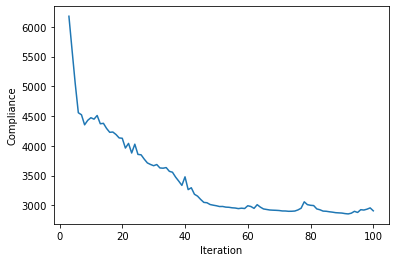

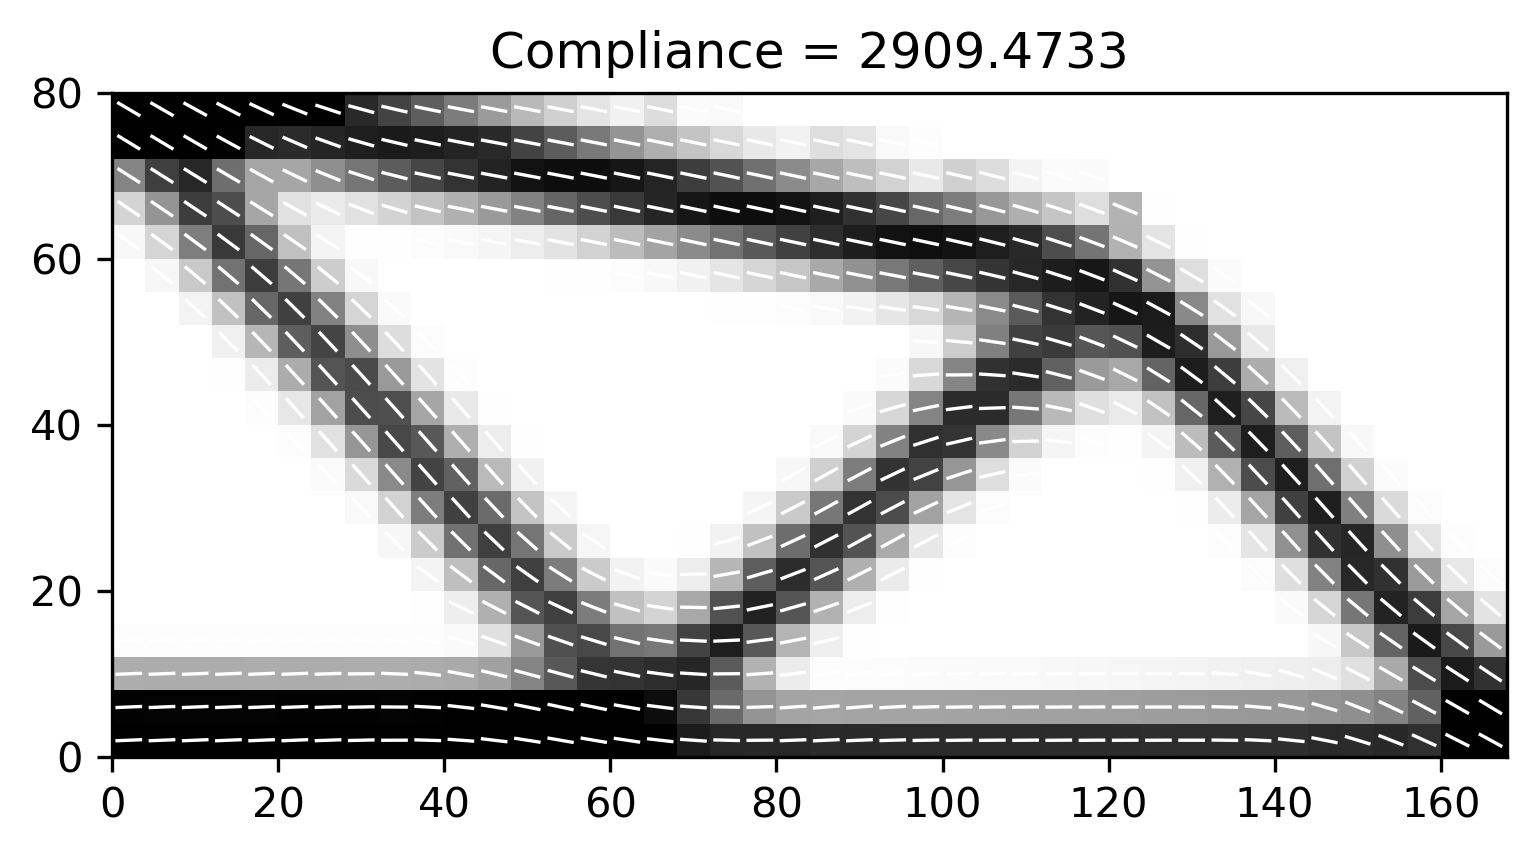

In [4]:
post1 = Post2D(solver1)
post1.plot_convergence(start_iter=3)
post1.plot()
print('CO2 footprint: {:.2f} kgCO2'.format(1000 * post1.CO2_footprint(rho, CO2mat, CO2veh)))

In [5]:
solver2 = TopOpt(inputfile='mbb3d', dim='3D_layer', jobname='3d',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.3, r_rho=8, r_theta=20, theta0=50, max_iter=100)
solver2.optim()

print()
print('Total elapsed time:     {:7.2f}s'.format(solver2.time))
print('FEA time:               {:7.2f}s'.format(solver2.fea_time))
print('Derivation time:        {:7.2f}s'.format(solver2.deriv_time))
print('Variable updating time: {:7.2f}s'.format(solver2.mma.update_time))

Iteration   0...  compliance = 44636.4407
Iteration   1...  compliance = 12802.0051
Iteration   2...  compliance =  8619.5963
Iteration   3...  compliance =  6068.7018
Iteration   4...  compliance =  5704.7560
Iteration   5...  compliance =  4588.6926
Iteration   6...  compliance =  4820.2950
Iteration   7...  compliance =  4407.7715
Iteration   8...  compliance =  4637.5119
Iteration   9...  compliance =  4439.0636
Iteration  10...  compliance =  4495.3482
Iteration  11...  compliance =  4540.0002
Iteration  12...  compliance =  4494.2097
Iteration  13...  compliance =  4525.9789
Iteration  14...  compliance =  4382.2871
Iteration  15...  compliance =  4312.7961
Iteration  16...  compliance =  4265.5684
Iteration  17...  compliance =  4237.7005
Iteration  18...  compliance =  4198.9128
Iteration  19...  compliance =  4105.4265
Iteration  20...  compliance =  4102.7226
Iteration  21...  compliance =  3989.8875
Iteration  22...  compliance =  3902.9736
Iteration  23...  compliance =  39

CO2 footprint: 2580.48 kgCO2


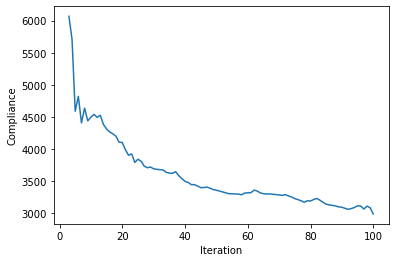

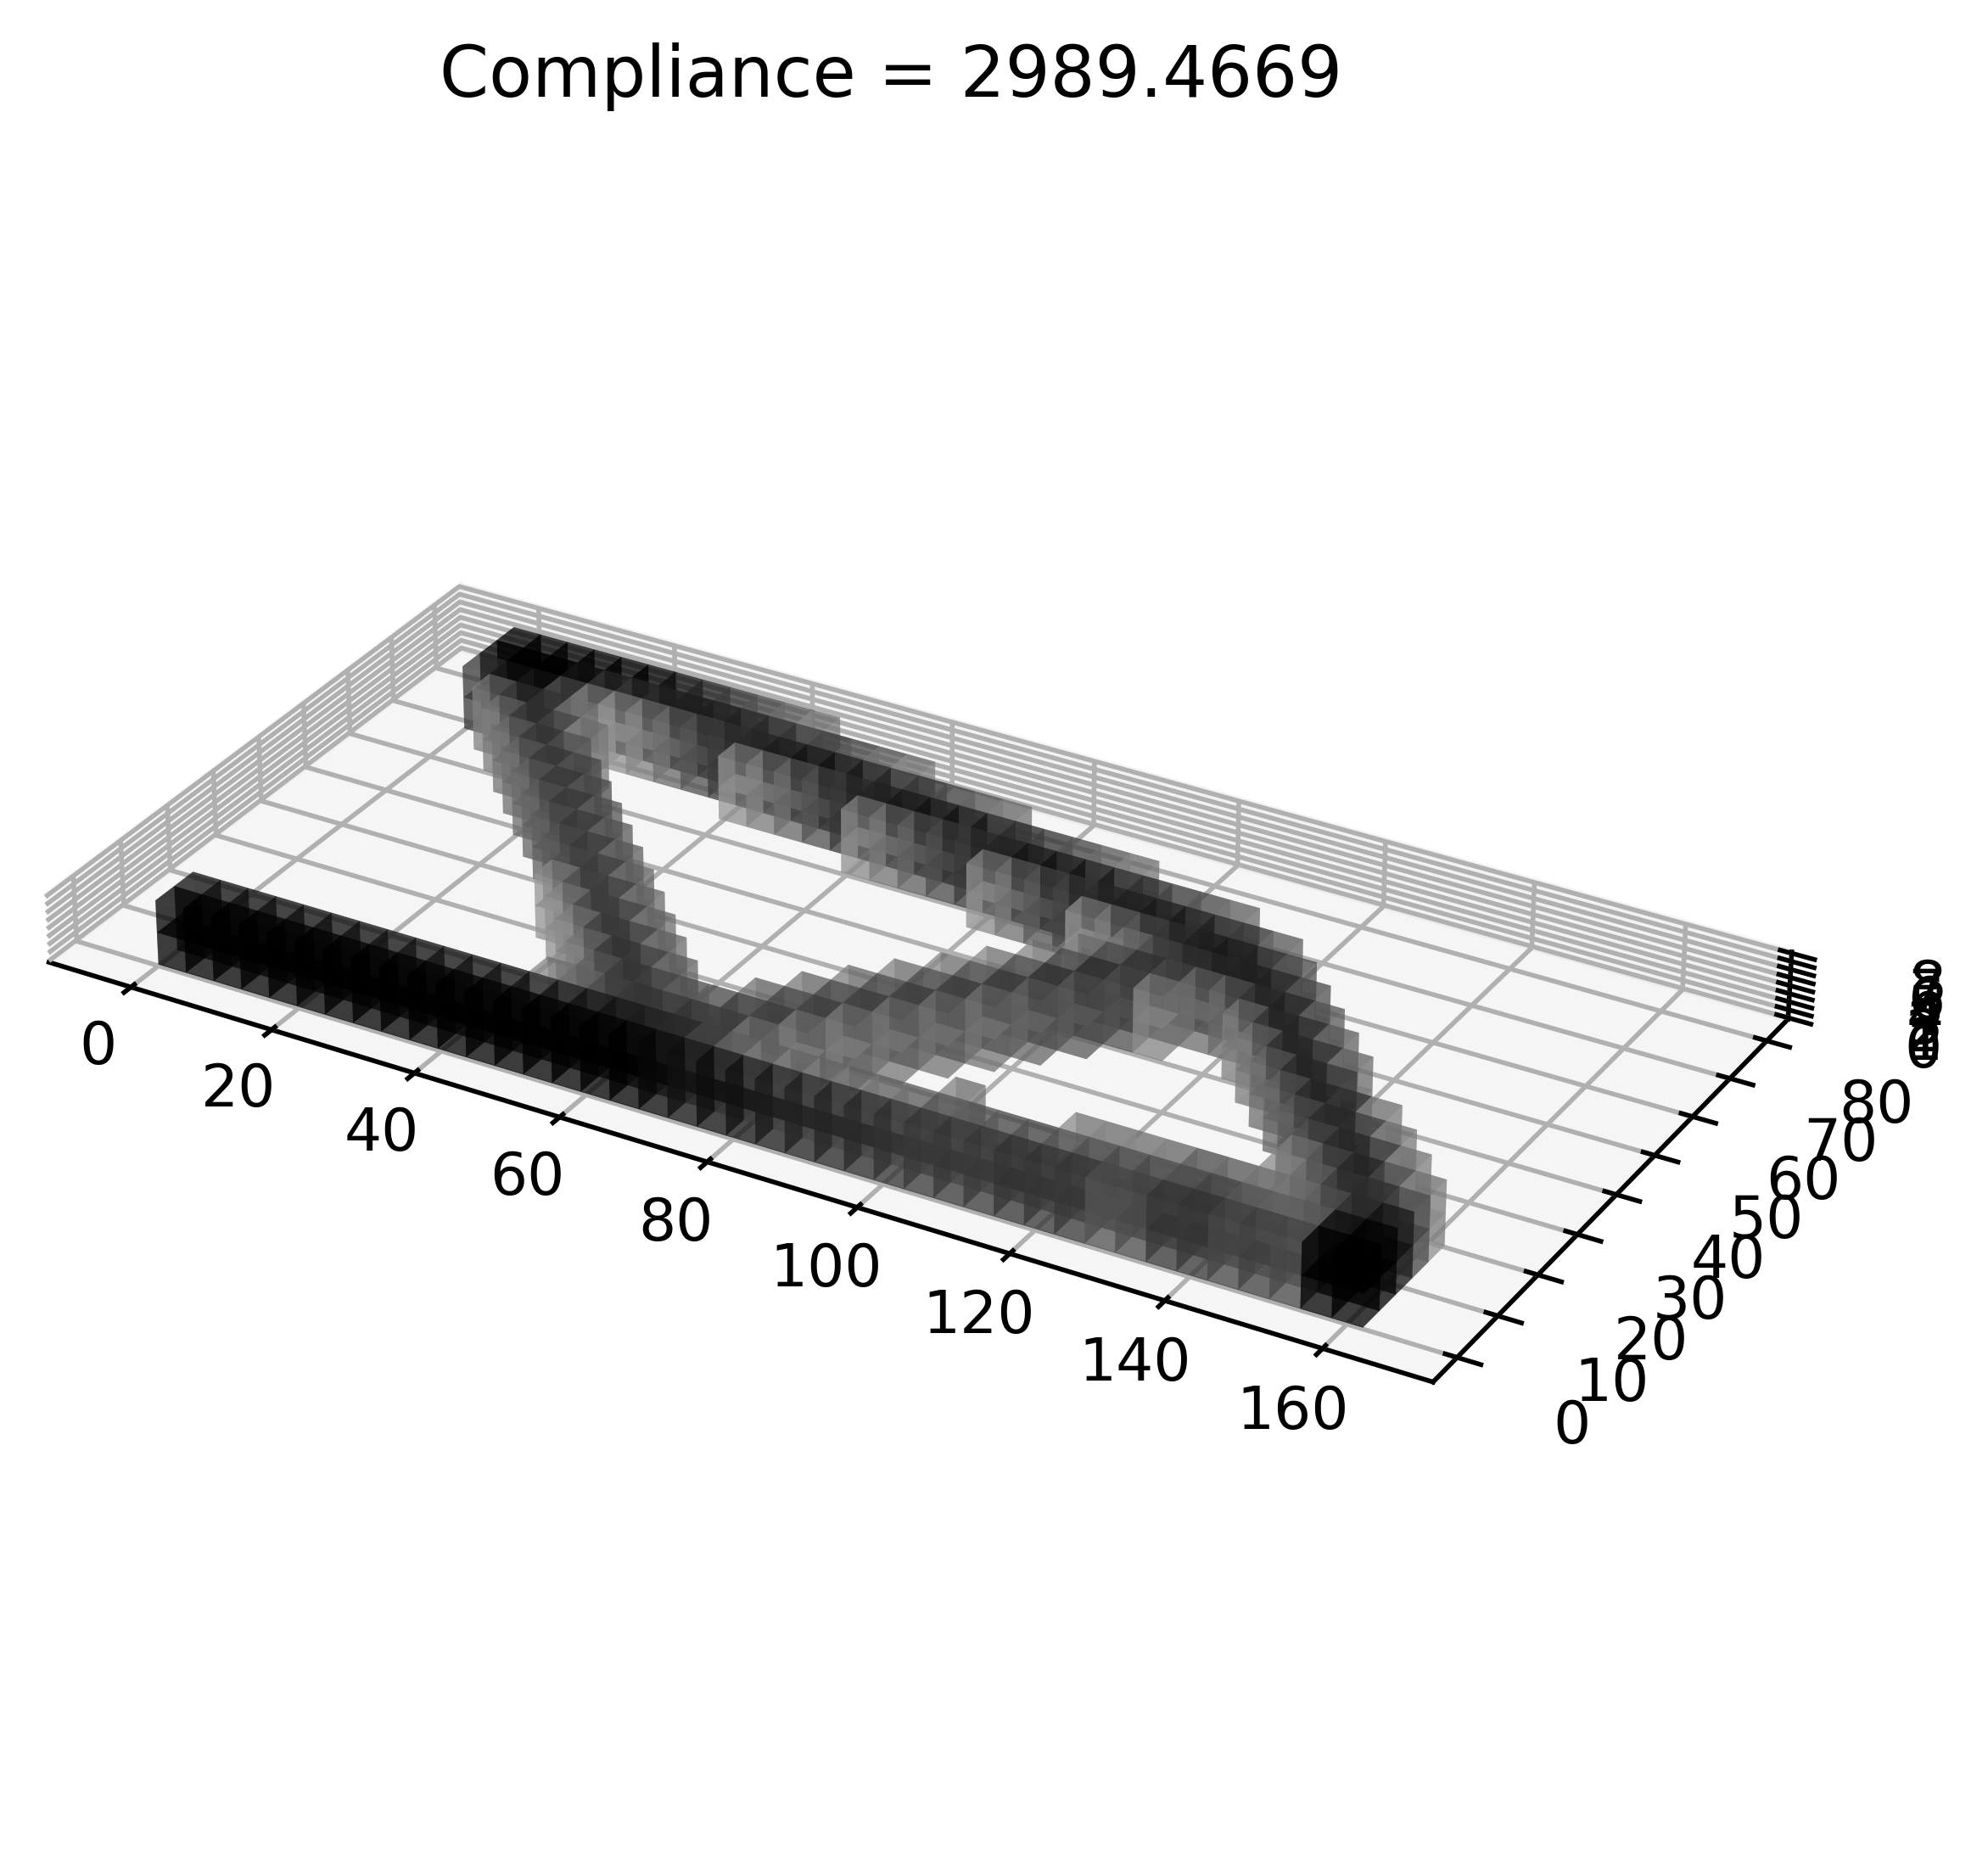

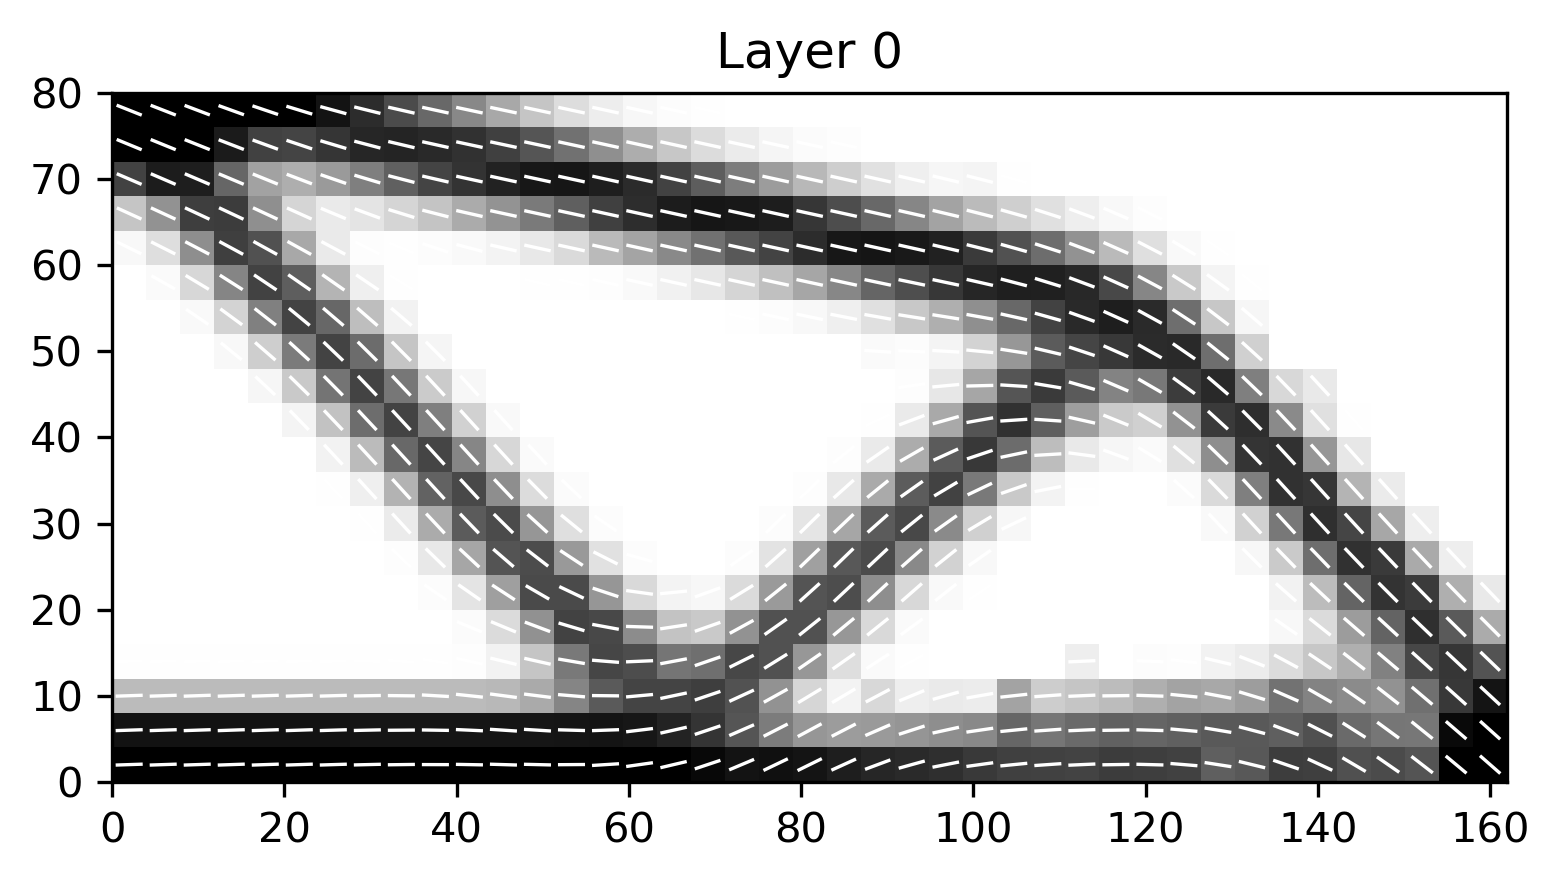

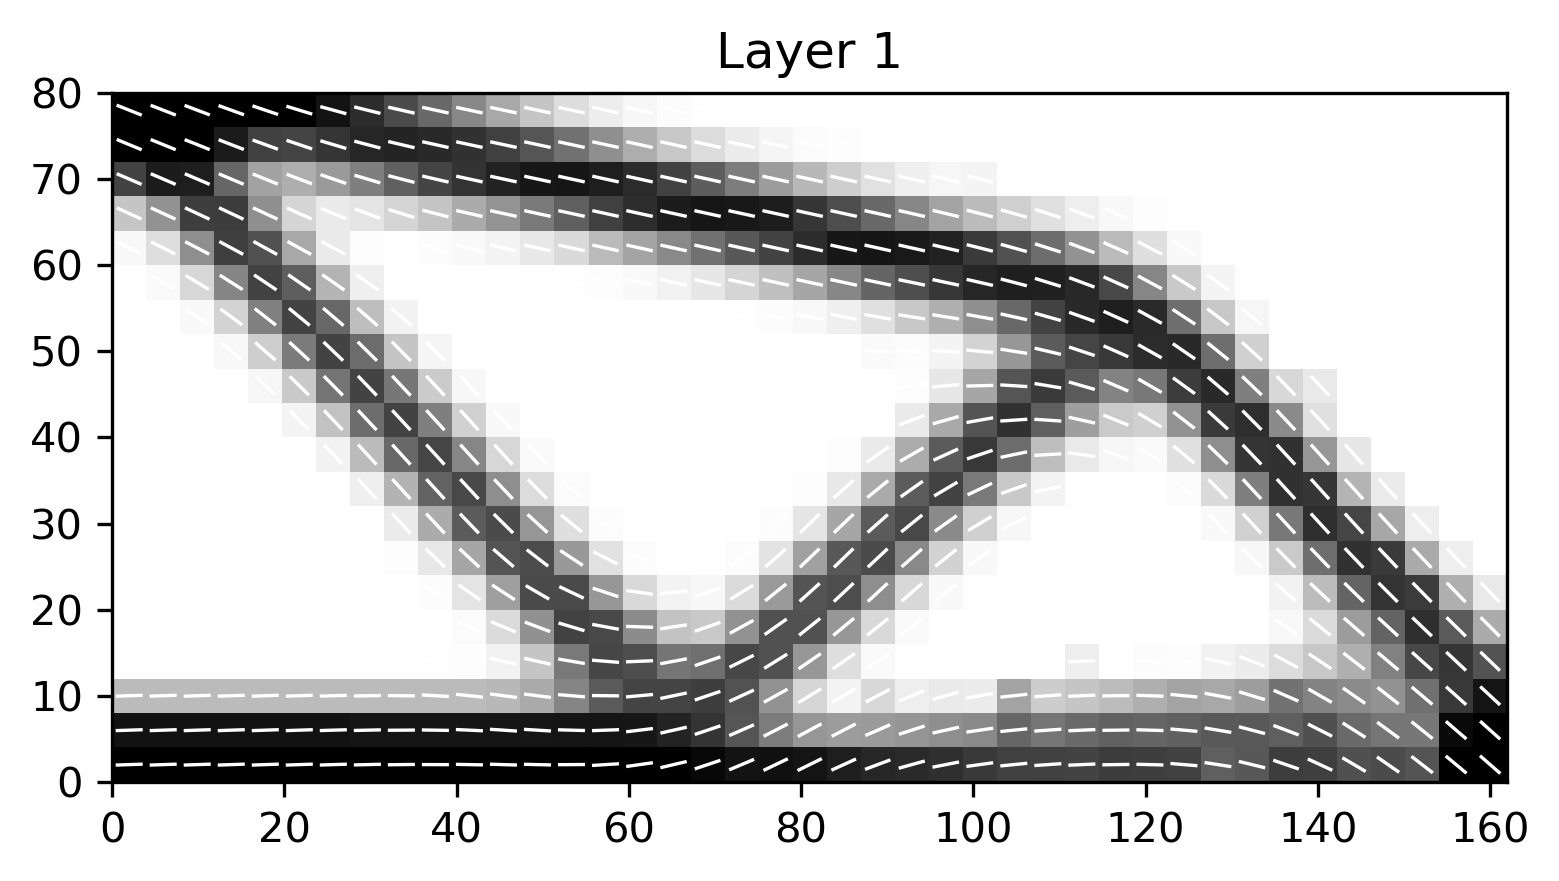

In [6]:
post2 = Post3D(solver2)
post2.plot_convergence(start_iter=3)
post2.plot()
post2.plot_layer(layer=0)
post2.plot_layer(layer=1)

print('CO2 footprint: {:.2f} kgCO2'.format(1000 * post2.CO2_footprint(rho, CO2mat, CO2veh)))